In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [3]:
# scaling function for input data
# Normalize위한 함수
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

In [5]:
# make dataset to input
# 입력으로 넣을 시계열 데이터셋[x, y] 생성
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [6]:
# hyper parameters
# 학습에 사용할 시계열 데이터
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [7]:
# load data
# 데이터 불러오기
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
# 불러온 데이터를 용도에 따라 두가지(학습, 테스트)로 분류
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data 
# 입력 데이터 normalize
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
# 앞서 구한 데이터들을 학습에 사용할 수 있게 데이터셋으로 가공
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
# 생성한 데이터셋들을 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

In [8]:
# 네트워크 생성
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        # RNN + FC
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [9]:
# loss & optimizer setting
# 로스함수, 최적화방식 선언
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [10]:
# start training
# 학습, 로스 출력
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item()) # 로스 출력

0 0.2271038442850113
1 0.18340937793254852
2 0.15106438100337982
3 0.12612313032150269
4 0.10598734766244888
5 0.08915018290281296
6 0.07493706792593002
7 0.06327901780605316
8 0.054496027529239655
9 0.04902385547757149
10 0.04693441092967987
11 0.04731706529855728
12 0.04838264361023903
13 0.04839478060603142
14 0.04633766785264015
15 0.04207771271467209
16 0.03620169684290886
17 0.029662011191248894
18 0.02338656224310398
19 0.018011242151260376
20 0.013800663873553276
21 0.010714654810726643
22 0.008532220497727394
23 0.006976508069783449
24 0.005824481137096882
25 0.004987422376871109
26 0.004524713382124901
27 0.0045546842738986015
28 0.005089899525046349
29 0.005920968484133482
30 0.006684894207865
31 0.007072674110531807
32 0.006973991170525551
33 0.006471904926002026
34 0.005753520876169205
35 0.005014692898839712
36 0.0043952930718660355
37 0.003953744191676378
38 0.0036766387056559324
39 0.0035109836608171463
40 0.0034013078548014164
41 0.0033151074312627316
42 0.003248894354

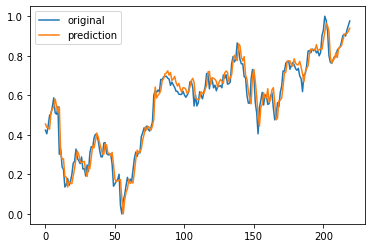

In [11]:
# 예측값과 실제값 비교
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()